In [3]:
import disgrid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [4]:
d = disgrid.Data("out_euler", spec=None)

In [5]:
d.avail()

{'fluids': {'gas': {'2d': ['dens', 'energy', 'vrad', 'vtheta'],
   '1d': ['rgy', 'd', 'eta', 'ma'],
   'scalar': ['time step',
    'analysis time step',
    'physical time',
    'mass',
    'radius',
    'angular momentum',
    'total energy',
    'internal energy',
    'kinematic energy',
    'potential energy',
    'radial kinetic energy',
    'azimuthal kinetic energy',
    'eccentricity',
    'periastron',
    'viscous dissipation',
    'luminosity',
    'pdivv',
    'inner boundary mass inflow',
    'inner boundary mass outflow',
    'outer boundary mass inflow',
    'outer boundary mass outflow',
    'wave damping inner mass creation',
    'wave damping inner mass removal',
    'wave damping outer mass creation',
    'wave damping outer mass removal',
    'density floor mass creation',
    'aspect ratio',
    'indirect term nbody x',
    'indirect term nbody y',
    'indirect term disk x',
    'indirect term disk y',
    'snapshot number',
    'monitor number',
    'hydrostep num

/tmp/ipykernel_999772/3773315725.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis")


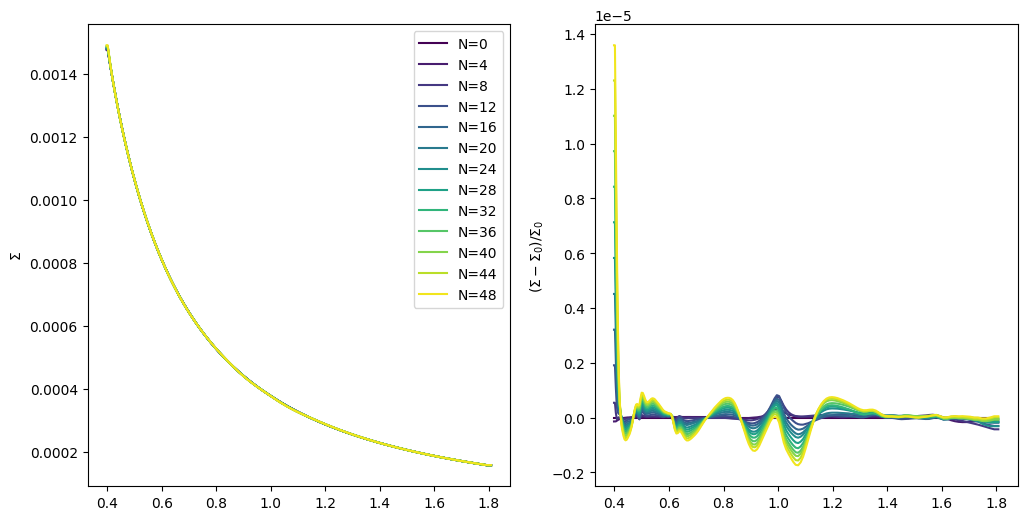

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

sigma = d.get(dim="2d", var="mass density", N=0)
sigma1d0 = np.average(sigma.data, axis=1)
Nmax = d.avail()["Nsnapshots"]
cmap = mpl.cm.get_cmap("viridis")
for n in range(0, Nmax, max(1, Nmax//10)):
    sigma = d.get(dim="2d", var="mass density", N=n)
    sigma1d = np.average(sigma.data, axis=1)
    rs = sigma.grid.get_coordinates("r")
    reldiff = (sigma1d - sigma1d0)#/sigma1d0
    color = cmap(n/Nmax)
    axes[0].plot(rs, sigma1d, label=f"N={n}", color=color)
    axes[1].plot(rs, reldiff, color=color)
axes[0].set_ylabel(r"$\Sigma$")
axes[1].set_ylabel(r"$(\Sigma - \Sigma_0) / \Sigma_0$")
axes[0].legend()

(-0.2, 0.2)

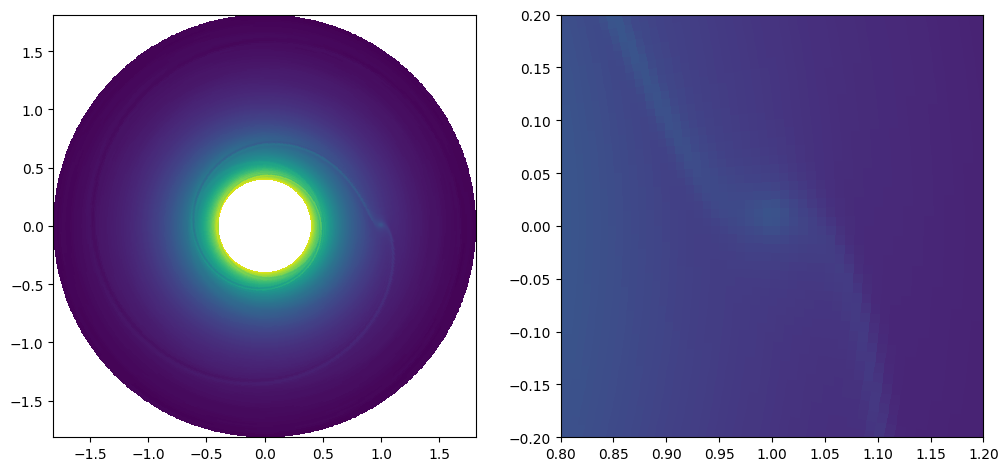

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

sigma = d.get(dim="2d", var="mass density", N=Nmax-1)
sigma1d = np.average(sigma.data, axis=1)
rs = sigma.grid.get_interfaces("r")
phis = sigma.grid.get_interfaces("phi")
PHIS, RS = np.meshgrid(phis, rs)
X = RS*np.cos(PHIS)
Y = RS*np.sin(PHIS)

ax = axes[0]
ax.pcolormesh(X.value,Y.value, sigma.data.value)
ax.set_aspect("equal")

ax = axes[1]
ax.pcolormesh(X.value,Y.value, sigma.data.value)
ax.set_aspect("equal")
ax.set_xlim(0.8,1.2)
ax.set_ylim(-0.2,0.2)

alpha 1.5
beta 1
q 2e-05
h 0.05
SigmaP 0.000376
OmegaP 1
b 0.020000000000000004
expected torque -4.049999999999999
output/monitor/planet2.dat not found


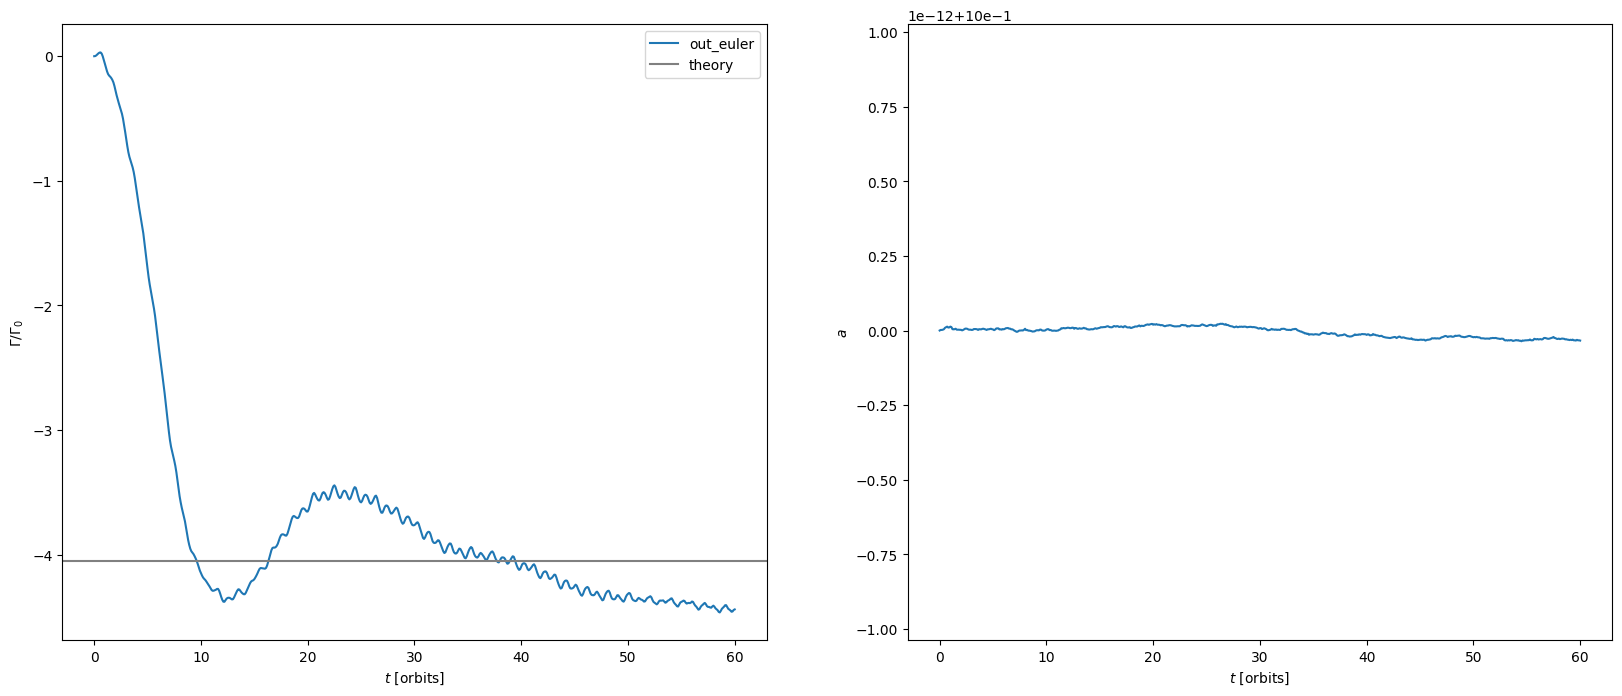

In [11]:
import yaml
with open("torque_test.yml", "r") as infile:
    params = yaml.safe_load(infile)

alpha = params["SigmaSlope"] #1.5 # - surface density power law index
flaringindex = params["FlaringIndex"]
beta = 1-2*flaringindex #1 # - temperature power law index
q = float(params["nbody"][1]["mass"])/float(params["nbody"][0]["mass"]) #2e-5 # reduced planet mass
h = params["AspectRatio"]#0.05 # aspect ratio
SigmaP = 3.76e-4 # Surface density at planet location
OmegaP = 1#2*np.pi
b = h*params["ThicknessSmoothing"] #0.4*h # smoothing lenght factor

Gamma0 = (q/h)**2 * SigmaP * OmegaP**2
# Paardekooper et al 2009

expected_torque = -(2.5 + 1.7*beta - 0.1*alpha) * (0.4/(b/h))**0.71

print("alpha", alpha)
print("beta", beta)
print("q", q)
print("h", h)
print("SigmaP", SigmaP)
print("OmegaP", OmegaP)
print("b", b)
print("expected torque", expected_torque)


fig, axes = plt.subplots(ncols=2, figsize=(20,8))

dirs = []
for name in os.listdir("output/"):
    dirs.append(f"output/{name}")

for outdir in dirs:

    fname = f"{outdir}/monitor/planet2.dat"
    name = outdir.rstrip("/").split("/")[-1]
    try:
        time, torque, a = np.genfromtxt(fname, usecols=(6,17,11), unpack=True)
    except OSError:
        print(f"{fname} not found")
        continue
    time = time/(2*np.pi)
    axes[0].plot(time, torque/Gamma0, label=name)
    axes[1].plot(time, a)

axes[0].set_xlabel(r"$t$ [orbits]")
axes[0].set_ylabel(r"$\Gamma / \Gamma_0$")


axes[1].set_xlabel(r"$t$ [orbits]")
axes[1].set_ylabel(r"$a$")

axes[0].axhline(expected_torque, color="gray", label="theory")
axes[0].legend()

plt.show()